## Collect Images Using OpenCV

In [2]:
import tensorflow as tf

In [3]:
import os
import time
import uuid
import cv2

In [9]:
IMAGES_PATH = os.path.join('data','images')

In [10]:
number_images = 30

In [20]:
cap = cv2.VideoCapture(1)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

#### Annotate Images with LabelMe

In [21]:
!labelme

2024-03-03 20:30:34,012 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\HP\.labelmerc


## Review Dataset and Build Image Loading Function

#### Import libraries

In [4]:
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Load Image into TF Data Pipeline

In [26]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [28]:
images.as_numpy_iterator().next()

b'data\\images\\76dfd9f6-d968-11ee-9950-202b201b519e.jpg'

In [5]:
def load_images(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [31]:
images = images.map(load_images)

In [32]:
images.as_numpy_iterator().next()

array([[[36, 27, 22],
        [37, 28, 23],
        [38, 29, 24],
        ...,
        [32, 23, 14],
        [32, 23, 14],
        [32, 23, 14]],

       [[36, 27, 22],
        [37, 28, 23],
        [38, 29, 24],
        ...,
        [33, 24, 15],
        [33, 24, 15],
        [33, 24, 15]],

       [[37, 28, 23],
        [37, 28, 23],
        [38, 29, 24],
        ...,
        [35, 26, 17],
        [35, 26, 17],
        [35, 26, 17]],

       ...,

       [[92, 92, 58],
        [96, 96, 62],
        [96, 96, 62],
        ...,
        [80, 54, 41],
        [81, 55, 42],
        [82, 56, 43]],

       [[93, 93, 59],
        [96, 96, 62],
        [94, 94, 60],
        ...,
        [77, 51, 38],
        [78, 52, 39],
        [79, 53, 40]],

       [[93, 93, 59],
        [95, 95, 61],
        [92, 92, 58],
        ...,
        [75, 49, 36],
        [76, 50, 37],
        [77, 51, 38]]], dtype=uint8)

In [33]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

#### View Raw Images with Matplotlib

In [34]:
image_generator = images.batch(4).as_numpy_iterator()

In [35]:
plot_images = image_generator.next()

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

#### MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [39]:
113*.7 #79 train data

79.1

In [48]:
113*.15 #17 test data 17 val data

16.95

In [55]:
79+17+17

113

#### Move the Matching Labels

In [56]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)

#### Apply Image Augmentation on Images and Labels using Albumentations

In [87]:
import os
import json

def fix_flipped_bounding_boxes(data_dir):
  """
  This function iterates through JSON files in a directory,
  checks for flipped bounding boxes, and corrects them.

  Args:
      data_dir: Path to the directory containing JSON files.
  """
  for filename in os.listdir(data_dir):
    if filename.endswith(".json"):
      # Construct file path
      filepath = os.path.join(data_dir, filename)
      # Read JSON data
      with open(filepath, "r") as f:
        data = json.load(f)

      # Check and fix each bounding box
      for shape in data["shapes"]:
        points = shape["points"]
        if points[0][1] > points[1][1]:  # Check for flipped y-coordinates
          points[0], points[1] = points[1], points[0]  # Swap y-coordinates

      # Save the modified data
      with open(filepath, "w") as f:
        json.dump(data, f, indent=2)  # Save with indentation for readability

# Replace "path/to/your/data/directory" with the actual path
fix_flipped_bounding_boxes("data/train/labels")

In [88]:
fix_flipped_bounding_boxes("data/test/labels")

In [89]:
fix_flipped_bounding_boxes("data/val/labels")

In [90]:
import albumentations as alb

In [91]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [108]:
img = cv2.imread(os.path.join('data','train', 'images','5413629a-d968-11ee-b06a-202b201b519e.jpg'))

In [109]:
img 

array([[[ 32,  35,  49],
        [ 29,  32,  46],
        [ 27,  30,  44],
        ...,
        [ 22,  30,  43],
        [ 22,  30,  43],
        [ 22,  30,  43]],

       [[ 32,  35,  49],
        [ 29,  32,  46],
        [ 27,  30,  44],
        ...,
        [ 22,  30,  43],
        [ 22,  30,  43],
        [ 22,  30,  43]],

       [[ 31,  34,  48],
        [ 30,  33,  47],
        [ 28,  31,  45],
        ...,
        [ 22,  30,  43],
        [ 22,  30,  43],
        [ 22,  30,  43]],

       ...,

       [[ 72, 107, 111],
        [ 74, 109, 113],
        [ 72, 107, 111],
        ...,
        [ 49,  66,  93],
        [ 48,  65,  92],
        [ 47,  64,  91]],

       [[ 74, 109, 113],
        [ 74, 109, 113],
        [ 70, 105, 109],
        ...,
        [ 48,  65,  92],
        [ 47,  64,  91],
        [ 46,  63,  90]],

       [[ 75, 110, 114],
        [ 74, 109, 113],
        [ 69, 104, 108],
        ...,
        [ 48,  65,  92],
        [ 46,  63,  90],
        [ 45,  62,  89]]

In [110]:
with open(os.path.join('data', 'train', 'labels','5413629a-d968-11ee-b06a-202b201b519e.json'), 'r') as f:
    label = json.load(f)

In [111]:
label

{'version': '5.4.1',
 'flags': {},
 'shapes': [{'label': 'face',
   'points': [[313.05555555555554, 99.44444444444444],
    [430.27777777777777, 312.77777777777777]],
   'group_id': None,
   'description': '',
   'shape_type': 'rectangle',
   'flags': {},
   'mask': None}],
 'imagePath': '..\\images\\5413629a-d968-11ee-b06a-202b201b519e.jpg',
 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHgAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAV

In [112]:
label['shapes']

[{'label': 'face',
  'points': [[313.05555555555554, 99.44444444444444],
   [430.27777777777777, 312.77777777777777]],
  'group_id': None,
  'description': '',
  'shape_type': 'rectangle',
  'flags': {},
  'mask': None}]

In [113]:
label['shapes'][0]['label']

'face'

In [114]:
label['shapes'][0]['points']

[[313.05555555555554, 99.44444444444444],
 [430.27777777777777, 312.77777777777777]]

In [115]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [116]:
coords

[313.05555555555554, 99.44444444444444, 430.27777777777777, 312.77777777777777]

In [117]:
coords = list(np.divide(coords, [640,480,640,480]))

In [118]:
coords

[0.4891493055555555,
 0.20717592592592593,
 0.6723090277777778,
 0.6516203703703703]

#### Apply Augmentations and View Results

In [119]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [120]:
augmented['bboxes'][0][2:]

(0.6798765432098766, 0.6417283950617284)

In [121]:
augmented['bboxes']

[(0.4193827160493827,
  0.16765432098765432,
  0.6798765432098766,
  0.6417283950617284)]

In [ ]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])
plt.show()

#### Build and Run Augmentation Pipeline

In [124]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 
                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

#### Load Augmented Images to Tensorflow Dataset

In [196]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_images)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [197]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_images)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [198]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_images)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [199]:
train_images.as_numpy_iterator().next()

array([[[0.1872549 , 0.14803922, 0.1127451 ],
        [0.17450981, 0.12352941, 0.09215686],
        [0.18186274, 0.13088235, 0.09950981],
        ...,
        [0.2810049 , 0.22610295, 0.17806372],
        [0.26060048, 0.20569853, 0.16256127],
        [0.2338848 , 0.17898284, 0.14074755]],

       [[0.19283088, 0.15361519, 0.11832108],
        [0.18566176, 0.13468137, 0.10330883],
        [0.18627451, 0.13529412, 0.10392157],
        ...,
        [0.23345588, 0.17855392, 0.13639706],
        [0.23419118, 0.17928922, 0.14313726],
        [0.2341299 , 0.17922795, 0.14393382]],

       [[0.18970588, 0.1504902 , 0.11519608],
        [0.19901961, 0.14803922, 0.11666667],
        [0.19613971, 0.14515932, 0.11378676],
        ...,
        [0.23566176, 0.1807598 , 0.14546569],
        [0.26954657, 0.21464461, 0.1793505 ],
        [0.28866422, 0.23376225, 0.19846813]],

       ...,

       [[0.17432599, 0.24883579, 0.4086397 ],
        [0.1807598 , 0.25526962, 0.42046568],
        [0.16519608, 0

## Prepare Labels

#### Build Label Loading Function

In [6]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

#### Load Labels to Tensorflow Dataset

In [201]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [202]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [203]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [204]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.3103 , 0.09656, 0.6855 , 0.6274 ], dtype=float16))

## Combine Label and Image Samples

#### Check Partition Lengths

In [205]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(4740, 4740, 1020, 1020, 1020, 1020)

#### Create Final Datasets (Images/Labels)

In [225]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [226]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [227]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1300)
val = val.batch(8)
val = val.prefetch(4)

In [228]:
train.as_numpy_iterator().next()[1]

(array([[0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.0663, 0.0736, 0.4724, 0.607 ],
        [0.3794, 0.3193, 0.718 , 0.7734],
        [0.    , 0.1545, 0.36  , 0.7397],
        [0.3264, 0.1484, 0.65  , 0.579 ],
        [0.53  , 0.161 , 1.    , 0.999 ],
        [0.557 , 0.2144, 0.831 , 0.724 ]], dtype=float16))

#### View Images and Annotations

In [238]:
data_samples = train.as_numpy_iterator()

In [239]:
res = data_samples.next()

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    # Convert the NumPy array to a cv::UMat object
    sample_image_um = cv2.UMat(sample_image)
    
    cv2.rectangle(sample_image_um, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype('int')),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype('int')), 
                  (255,0,0), 2)
    
    # Convert the cv::UMat object back to a NumPy array for displaying
    sample_image_with_rect = sample_image_um.get()
    
    ax[idx].imshow(sample_image_with_rect)


## Build Deep Learning using the Functional API

#### Import Layers and Base Network

In [242]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

#### Download VGG16

In [243]:
vgg = VGG16(include_top=False)



58889256/58889256 [==============================] - 11s 0us/step


In [244]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

#### Build instance of Network

In [245]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  face have or not
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model placing boxes in the faces or track face
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

#### Test out Neural Network

In [246]:
facetracker = build_model()

In [247]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

In [248]:
X, y = train.as_numpy_iterator().next()

In [250]:
X.shape

(8, 120, 120, 3)

In [252]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 1s 836ms/step


In [253]:
classes

array([[0.5018822 ],
       [0.51070833],
       [0.5343275 ],
       [0.47411552],
       [0.4135991 ],
       [0.4798312 ],
       [0.48951405],
       [0.41146794]], dtype=float32)

In [254]:
coords

array([[0.5026032 , 0.53253525, 0.40270907, 0.42593622],
       [0.5191201 , 0.5961942 , 0.45289034, 0.38752496],
       [0.63185585, 0.6091079 , 0.3902719 , 0.3864248 ],
       [0.5599587 , 0.58351886, 0.35219157, 0.45741   ],
       [0.6387103 , 0.568496  , 0.34891382, 0.55888265],
       [0.49067578, 0.5467015 , 0.41199306, 0.40513435],
       [0.65914375, 0.5513325 , 0.42256555, 0.4179002 ],
       [0.54051566, 0.434939  , 0.4063075 , 0.43697992]], dtype=float32)

## Define Losses and Optimizers

#### Define Optimizer and LR

In [259]:
batches_per_epoch = len(train)

In [260]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

#### Create Localization Loss and Classification Loss

In [261]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [262]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

#### Test out Loss Metrics

In [264]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=9.110285>

In [265]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.73415273>

In [266]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=9.110285>

## Train Neural Network

## Create Custom Model Class

In [267]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [268]:
model = FaceTracker(facetracker)

In [269]:
model.compile(opt, classloss, regressloss)

In [270]:
logdir='logs'

In [271]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [274]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
593/593 [==============================] - 878s 1s/step - total_loss: 0.3699 - class_loss: 0.1190 - regress_loss: 0.3104 - val_total_loss: 0.1248 - val_class_loss: 5.2325e-04 - val_regress_loss: 0.1245
Epoch 2/10
593/593 [==============================] - 946s 2s/step - total_loss: 0.2107 - class_loss: 0.0642 - regress_loss: 0.1786 - val_total_loss: 0.1457 - val_class_loss: 3.9958e-04 - val_regress_loss: 0.1455
Epoch 3/10
593/593 [==============================] - 873s 1s/step - total_loss: 0.1664 - class_loss: 0.0490 - regress_loss: 0.1419 - val_total_loss: 0.0671 - val_class_loss: 1.9500e-04 - val_regress_loss: 0.0670
Epoch 4/10
593/593 [==============================] - 884s 1s/step - total_loss: 0.1531 - class_loss: 0.0458 - regress_loss: 0.1302 - val_total_loss: 0.1884 - val_class_loss: 9.3528e-04 - val_regress_loss: 0.1880
Epoch 5/10
593/593 [==============================] - 901s 2s/step - total_loss: 0.0833 - class_loss: 0.0237 - regress_loss: 0.0715 - val_total_loss

#### Plot Performance

In [277]:
 hist.history

{'total_loss': [0.03127647563815117,
  0.04230546951293945,
  0.15877801179885864,
  0.031185707077383995,
  0.09870008379220963,
  0.019452866166830063,
  0.009094410575926304,
  0.0038339956663548946,
  0.01034656260162592,
  0.010389205999672413],
 'class_loss': [0.006305335089564323,
  0.00011423455725889653,
  0.14704175293445587,
  0.0005090800113976002,
  0.0011724643409252167,
  0.001979909371584654,
  0.0013310792855918407,
  0.0006653006421402097,
  0.003594860201701522,
  0.0002792608574964106],
 'regress_loss': [0.028123807162046432,
  0.042248353362083435,
  0.0852571427822113,
  0.03093116730451584,
  0.09811384975910187,
  0.018462911248207092,
  0.00842887070029974,
  0.0035013454034924507,
  0.008549132384359837,
  0.010249575600028038],
 'val_total_loss': [0.12481102347373962,
  0.14574357867240906,
  0.06714724749326706,
  0.18843813240528107,
  0.10594159364700317,
  0.023605719208717346,
  0.11802989989519119,
  0.008428329601883888,
  0.03287637233734131,
  0.0410

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

## Make Predictions

In [288]:
test_data = test.as_numpy_iterator()

In [289]:
test_sample = test_data.next()

In [290]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 393ms/step


In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    sample_image_um = cv2.UMat(sample_image)
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image_um, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    sample_image_with_rect = sample_image_um.get()
    
    ax[idx].imshow(sample_image_with_rect)

## Save the Model

In [8]:
from tensorflow.keras.models import load_model

In [293]:
facetracker.save('facetracker.h5')

C:\Users\HP\DeepLearning\FaceDetection\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### Load Model

In [19]:
face = load_model('facetracker.h5')

In [20]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_images)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [21]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [22]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [23]:
test_data = test.as_numpy_iterator()

In [24]:
test_sample = test_data.next()

In [25]:
yhat = face.predict(test_sample[0])

1/1 [==============================] - 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


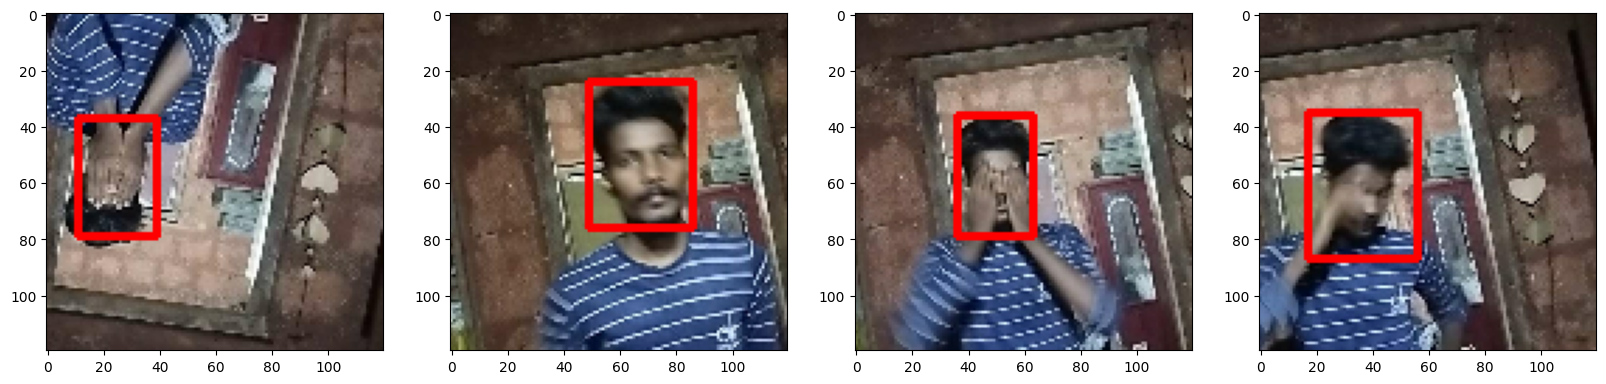

In [26]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    sample_image_um = cv2.UMat(sample_image)
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image_um, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    sample_image_with_rect = sample_image_um.get()
    
    ax[idx].imshow(sample_image_with_rect)

<b> I cleared multiple output cells because they contained my personal data, leaving only one for evaluation accuracy </b>

## Real Time Detection

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = face.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450])//.astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()